In [ ]:
#| default_exp utils.datasets
# | hide
import nbdev
from nbdev.showdoc import *

nbdev.nbdev_export()

In [ ]:
# |export
import os
import requests
import numpy as np
import gzip

from tidygrad.utils.data import Dataset, download_file, DataLoader

In [ ]:
#| export

from tidygrad.utils.data import download_file
from pathlib import Path
#| export

def load_mnist(path, url):
    file_path = Path(path) / "mnist.npz"
    download_file(file_path, url+"mnist.npz")
    with np.load(file_path) as f:
        x_train, y_train = f["x_train"], f["y_train"]
        x_test, y_test = f["x_test"], f["y_test"]

        x_train = x_train.astype(np.float32)
        y_train = y_train.astype(np.int32)
        x_test = x_test.astype(np.float32)
        y_test = y_test.astype(np.int32)

    return (x_train, y_train), (x_test, y_test)

def load_fashion_mnist(path, url_base):
    filenames = ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz", "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]
    for f in filenames:
        download_file(path / f, url_base + f)

    with gzip.open(path / filenames[0], "rb") as f:
        x_train = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

    with gzip.open(path / filenames[1], "rb") as f:
        y_train = np.frombuffer(f.read(), np.uint8, offset=8)

    with gzip.open(path / filenames[2], "rb") as f:
        x_test = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

    with gzip.open(path / filenames[3], "rb") as f:
        y_test = np.frombuffer(f.read(), np.uint8, offset=8)

    return (x_train, y_train), (x_test, y_test)

class MNIST(Dataset):
    """MNIST Dataset"""
    def __init__(
        self,
        path="datasets",
        url=None,
        train=True,
        item_tfms=(),
        fashion=False,
    ):
        self.item_tfms = item_tfms
        self.path = Path(path)
        self.train = train

        url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/" if url is None else url

        if fashion:
            (self.x_train, self.y_train), (self.x_test, self.y_test) = load_fashion_mnist(self.path, url)
        else:
            (self.x_train, self.y_train), (self.x_test, self.y_test) = load_mnist(self.path, url)

        if self.train:
            self.x, self.y = self.x_train, self.y_train
        else:
            self.x, self.y = self.x_test, self.y_test

    def __getitem__(self, idx):
        if not isinstance(idx, int):
            raise TypeError("Index must be an integer.")

        x, y = self.x[idx], self.y[idx]
        for tfm in self.item_tfms:
            x, y = tfm(x, y)
        return x, y

    def __len__(self):
        return len(self.x)

    def shuffle(self):
        idx = np.random.permutation(len(self))
        self.x, self.y = self.x[idx], self.y[idx]

    def collate_fn(self, batch: list):
        return np.stack([item[0] for item in batch]), np.stack([item[1] for item in batch])

In [ ]:
#| export
def mnist_batch_tfm(x, y):
    return (x.reshape(x.shape[0], -1) / 255 - 0.5, y)

In [ ]:
from matplotlib import pyplot as plt
from lovely_numpy import Lo

File datasets/mnist.npz already exists


(array[60000, 28, 28] f32 n=47040000 (0.2Gb) x∈[0., 255.000] μ=33.318 σ=78.567,
 array[60000] i32 0.2Mb x∈[0, 9] μ=4.454 σ=2.889,
 array[28, 28] f32 n=784 (3.1Kb) x∈[0., 255.000] μ=35.108 σ=79.649)

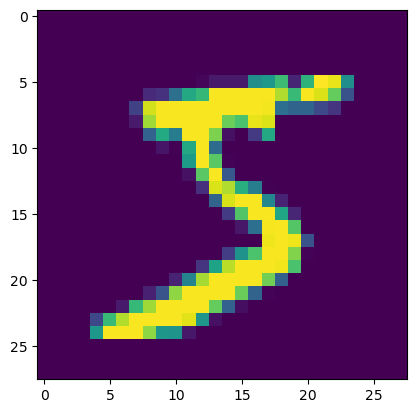

In [ ]:
mnist = MNIST()
plt.imshow(mnist.x[0])
Lo(mnist.x), Lo(mnist.y), Lo(mnist.x[0])

In [ ]:
mnist_dl = DataLoader(mnist, batch_size=64, batch_tfms=[mnist_batch_tfm])
x, y = next(iter(mnist_dl))
x, y

(Tensor[64, 784](name="?" op=Load):
     v=array[64, 784] f32 n=50176 (0.2Mb) x∈[-0.500, 0.500] μ=-0.368 σ=0.309
     ∇=array[64, 784] f32 n=50176 (0.2Mb) all_zeros,
 Tensor[64](name="?" op=Load):
     v=array[64] i32 x∈[0, 9] μ=4.719 σ=3.223
     ∇=array[64] f32 all_zeros)

<matplotlib.image.AxesImage>

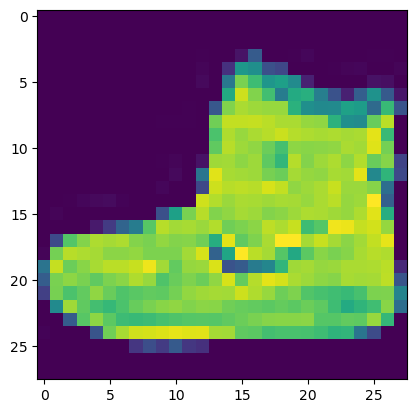

In [ ]:
mnist = MNIST(fashion=True)
plt.imshow(mnist.x[0])

In [ ]:
Lo(mnist.x), Lo(mnist.y), Lo(mnist.x[0])

(array[60000, 28, 28] u8 n=47040000 (45Mb) x∈[0, 255] μ=72.940 σ=90.021,
 array[60000] u8 59Kb x∈[0, 9] μ=4.500 σ=2.872,
 array[28, 28] u8 n=784 x∈[0, 255] μ=97.254 σ=101.792)